In [1]:
import sys

import numpy as np
import xarray as xr

sys.path.append('../src/lib/')
import plot

In [2]:
def standardize(x, dim):
    x = x - x.mean(dim)
    x = x / x.std(dim)
    x.name = 'standardized ' + x.name
    return x

In [3]:
def cor(x, dim):
    other_dim = [d for d in x.dims if d != dim]
    assert(len(other_dim) == 1)
    other_dim = other_dim[0]
    x = x.transpose(other_dim, dim)
    cor_a = np.corrcoef(x.values)
    return xr.DataArray(
        cor_a,
        dims=(other_dim, other_dim),
        coords={other_dim: x.coords[other_dim]},
        name='pearson correlation'
    )

In [32]:
def flat(x):
    a = np.array(x.values.flat)
    return xr.DataArray(
        a,
        dims={'flattened': a.shape},
        name=x.name,
    )

## Load Data ##

In [4]:
ds = dict()
for trans in ['lin', 'sqrt', 'cbrt']:
    ds[trans] = xr.open_dataset('../data/processed/mri-features-reg-volume-{}.nc'.format(trans)).load()
ds['no_reg'] = xr.open_dataset('../data/processed/mri-features.nc').load()
ds['no_reg']['cbrt(volume)'] = np.cbrt(ds['no_reg']['volume'])

Make data into a feature matrix.

In [5]:
feature_mat = dict()
for trans in ds.keys():
    sel_var = [n for n, v in ds[trans].items() if v.dtype == np.dtype('float64')]
    sel_var = list(set(sel_var) - {'MultiFocal'})
    m = xr.concat(
        [ds[trans][v] for v in sel_var],
        xr.DataArray(sel_var, dims='feature', name='feature'),
    )
    m.name = 'value'
    m = m.sel(case=np.isnan(m).sum('feature') == 0)
    feature_mat[trans] = m

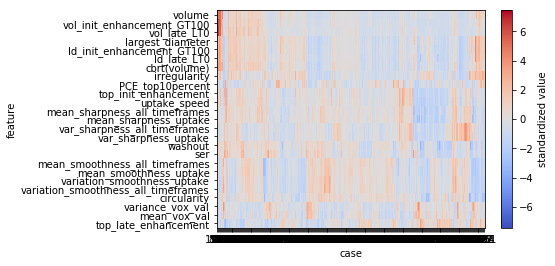

In [6]:
plot.heatmap(standardize(feature_mat['no_reg'], 'case'),
             row_dendrogram=True, row_dist_metric='correlation',
             col_dendrogram=True, col_dist_metric='euclidean')

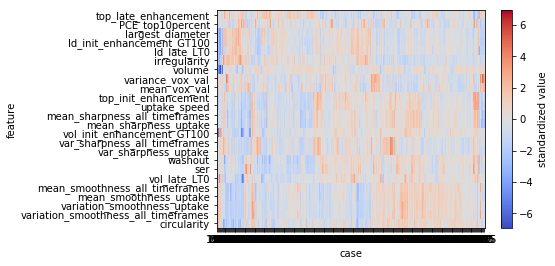

In [7]:
plot.heatmap(standardize(feature_mat['lin'], 'case'),
             row_dendrogram=True, row_dist_metric='correlation',
             col_dendrogram=True, col_dist_metric='euclidean')

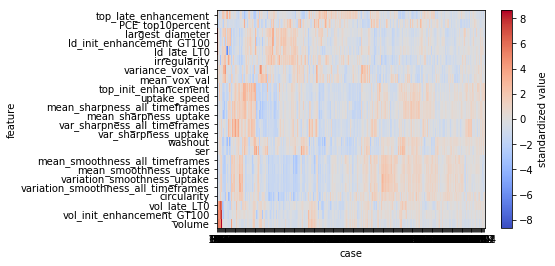

In [8]:
plot.heatmap(standardize(feature_mat['cbrt'], 'case'),
             row_dendrogram=True, row_dist_metric='correlation',
             col_dendrogram=True, col_dist_metric='euclidean')

In [9]:
no_alltf = [s for s in feature_mat['lin'].coords['feature'].values if s.split('_')[-1] != 'timeframes']

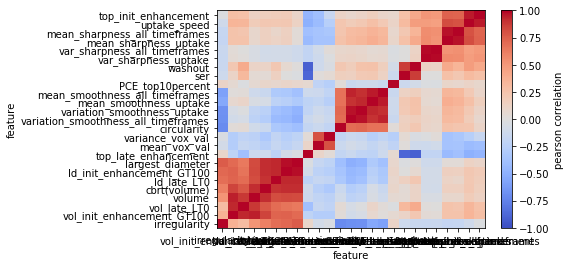

In [10]:
plot.heatmap(cor(feature_mat['no_reg'], 'case'),
             row_dendrogram=True, symmetric=True)

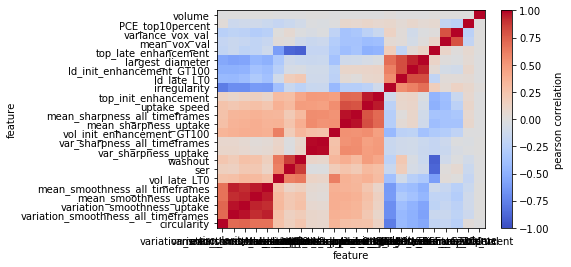

In [11]:
plot.heatmap(cor(feature_mat['lin'], 'case'),
             row_dendrogram=True, symmetric=True)

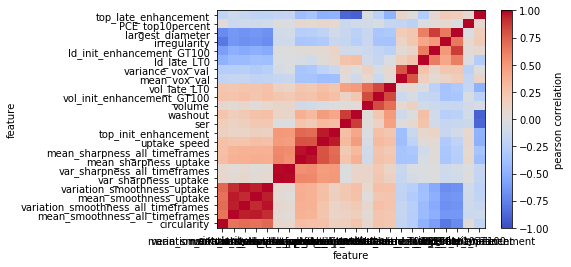

In [12]:
plot.heatmap(cor(feature_mat['cbrt'], 'case'),
             row_dendrogram=True, symmetric=True)

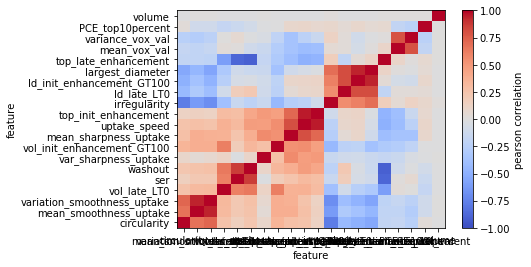

In [13]:
plot.heatmap(cor(feature_mat['lin'].sel(feature=no_alltf), 'case'),
             row_dendrogram=True, symmetric=True)

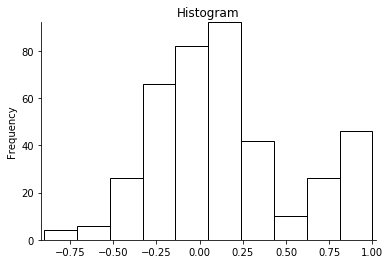

In [35]:
plot.hist(flat(cor(feature_mat['no_reg'].sel(feature=no_alltf), 'case')))

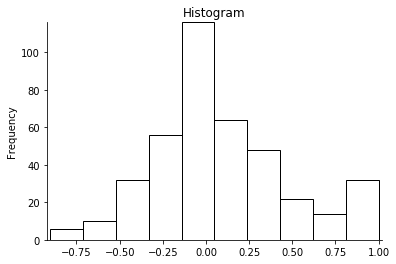

In [36]:
plot.hist(flat(cor(feature_mat['lin'].sel(feature=no_alltf), 'case')))

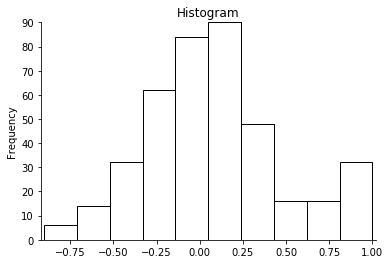

In [37]:
plot.hist(flat(cor(feature_mat['cbrt'].sel(feature=no_alltf), 'case')))